<a href="https://colab.research.google.com/github/NecibeGuner/Model_Egitimleri/blob/main/SwinVeCaitTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPU destekli PyTorch (CUDA otomatik olarak Colab'de desteklenir)
!pip install torch torchvision torchaudio
# Hugging Face Transformers kütüphanesi
!pip install transformers
# Bilimsel hesaplama ve görselleştirme kütüphaneleri
!pip install numpy scikit-learn matplotlib seaborn pillow
!pip install torch torchvision transformers scikit-learn matplotlib numpy
!pip install transformers torch torchvision matplotlib tqdm seaborn scikit-learn
!pip install --upgrade transformers
!pip install timm

In [ ]:
# @title swin  tiny
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SwinForImageClassification, AutoImageProcessor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

def prepare_dataset(directory, transform):
    file_paths = []
    labels = []
    class_to_idx = {}

    for idx, category in enumerate(sorted(os.listdir(directory))):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            class_to_idx[category] = idx
            for file_name in os.listdir(category_path):
                file_paths.append(os.path.join(category_path, file_name))
                labels.append(idx)

    dataset = CustomDataset(file_paths, labels, transform)
    return dataset, class_to_idx

# Load Swin image processor and define transformations
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# Paths to training and testing directories
train_dir = '/content/drive/MyDrive/Grup_36/ModelResimleri/train'
test_dir = '/content/drive/MyDrive/Grup_36/ModelResimleri/val'

# Check if the directories exist
if not os.path.exists(train_dir) or not os.listdir(train_dir):
    raise FileNotFoundError(f"Training directory not found or empty: {train_dir}")
if not os.path.exists(test_dir) or not os.listdir(test_dir):
    raise FileNotFoundError(f"Testing directory not found or empty: {test_dir}")

train_dataset, class_to_idx = prepare_dataset(train_dir, transform)
test_dataset, _ = prepare_dataset(test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load Swin-Tiny model
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=len(class_to_idx),
    ignore_mismatched_sizes=True
)

# Reinitialize classifier to match the number of classes
model.classifier = torch.nn.Linear(model.config.hidden_size, len(class_to_idx))
torch.nn.init.xavier_uniform_(model.classifier.weight)
torch.nn.init.zeros_(model.classifier.bias)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

BEST_MODEL_PATH = "/content/drive/MyDrive/swin_tiny_best_model.pth"

def train_model_with_early_stopping(model, train_loader, test_loader, optimizer, epochs=20, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    start_time = time.time()

    try:
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            print(f"Epoch {epoch+1}/{epochs}")
            for images, labels in tqdm(train_loader, desc="Training", leave=False):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images).logits
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_accuracy = float(correct) / total if total > 0 else 0.0
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            val_loss, val_metrics = evaluate_model(model, test_loader, use_tqdm=True)
            val_accuracy = val_metrics['accuracy']
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                print(f"Validation loss improved to {val_loss:.4f}. Resetting patience counter.")
                torch.save(model.state_dict(), BEST_MODEL_PATH)
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    except Exception as e:
        print(f"Error during training: {e}")

    end_time = time.time()
    training_time = end_time - start_time

    plt.figure(figsize=(10, 6))
    try:
        # Ensure data is numeric and not dictionary-like
        train_accuracies = [float(acc) for acc in train_accuracies if isinstance(acc, (int, float))]
        val_accuracies = [float(acc) for acc in val_accuracies if isinstance(acc, (int, float))]

        plt.plot(train_losses, label="Train Loss", marker='o')
        plt.plot(val_losses, label="Validation Loss", marker='x')
        plt.plot(train_accuracies, label="Train Accuracy", linestyle='--', marker='o')
        plt.plot(val_accuracies, label="Validation Accuracy", linestyle='--', marker='x')
        plt.xlabel("Epochs")
        plt.ylabel("Metrics")
        plt.legend()
        plt.title("Training and Validation Loss and Accuracy")
        plt.show()
    except Exception as e:
        print(f"Error during plotting: {e}")

    print(f"Training Time: {training_time:.2f} seconds")

    return training_time

def evaluate_model_with_error_handling(model, data_loader, use_tqdm=False):
    try:
        return evaluate_model(model, data_loader, use_tqdm)
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return float('inf'), {'accuracy': 0, 'precision': 0, 'recall': 0, 'fscore': 0, 'sensitivity': 0, 'specificity': 0, 'auc': 0}

def inference_time_with_error_handling(model, test_loader):
    try:
        return inference_time(model, test_loader)
    except Exception as e:
        print(f"Error during inference: {e}")
        return float('inf')

# Training
training_time = train_model_with_early_stopping(model, train_loader, test_loader, optimizer)

# Load the best model
try:
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
except Exception as e:
    print(f"Error loading the best model: {e}")

# Evaluation
evaluate_model_with_error_handling(model, test_loader)

# Inference time
inference_duration = inference_time_with_error_handling(model, test_loader)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_duration:.2f} seconds")
print("Training and Evaluation Completed.")


Epoch 1/10


Confusion Matrix:
[[942  31   2  25   0]
 [ 33 912  12  39   4]
 [ 18   8 964  10   0]
 [ 22  28   0 935  14]
 [  3   6   0  13 978]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.93      0.94      0.93      1000
      CHCPOX       0.93      0.91      0.92      1000
       NEVUS       0.99      0.96      0.97      1000
 PSORİASİS       0.91      0.94      0.93       999
 VİTİLİGO       0.98      0.98      0.98      1000

    accuracy                           0.95      4999
   macro avg       0.95      0.95      0.95      4999
weighted avg       0.95      0.95      0.95      4999

Epoch 1/10, Train Loss: 0.3617, Train Accuracy: 0.8767
Validation Loss: 0.1628, Validation Accuracy: 0.9464
Validation loss improved to 0.1628. Resetting patience counter.
Epoch 2/10


Confusion Matrix:
[[897  58   5  28  12]
 [  4 950  14  24   8]
 [  6  10 980   3   1]
 [  6  36   3 919  35]
 [  0   2   0   5 993]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.98      0.90      0.94      1000
      CHCPOX       0.90      0.95      0.92      1000
       NEVUS       0.98      0.98      0.98      1000
 PSORİASİS       0.94      0.92      0.93       999
 VİTİLİGO       0.95      0.99      0.97      1000

    accuracy                           0.95      4999
   macro avg       0.95      0.95      0.95      4999
weighted avg       0.95      0.95      0.95      4999

Epoch 2/10, Train Loss: 0.0928, Train Accuracy: 0.9718
Validation Loss: 0.1552, Validation Accuracy: 0.9480
Validation loss improved to 0.1552. Resetting patience counter.
Epoch 3/10


Confusion Matrix:
[[967  24   3   5   1]
 [ 20 943  11  20   6]
 [  6   7 986   1   0]
 [ 38  33   7 908  13]
 [  2   1   0   3 994]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.94      0.97      0.95      1000
      CHCPOX       0.94      0.94      0.94      1000
       NEVUS       0.98      0.99      0.98      1000
 PSORİASİS       0.97      0.91      0.94       999
 VİTİLİGO       0.98      0.99      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 3/10, Train Loss: 0.0426, Train Accuracy: 0.9877
Validation Loss: 0.1441, Validation Accuracy: 0.9598
Validation loss improved to 0.1441. Resetting patience counter.
Epoch 4/10


Confusion Matrix:
[[959  35   2   4   0]
 [ 20 966   6   6   2]
 [  7   8 984   1   0]
 [ 23  55   2 916   3]
 [  5   6   0   9 980]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.95      0.96      0.95      1000
      CHCPOX       0.90      0.97      0.93      1000
       NEVUS       0.99      0.98      0.99      1000
 PSORİASİS       0.98      0.92      0.95       999
 VİTİLİGO       0.99      0.98      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 4/10, Train Loss: 0.0313, Train Accuracy: 0.9897
Validation Loss: 0.1549, Validation Accuracy: 0.9612
Validation loss did not improve. Patience counter: 1/20
Epoch 5/10


Confusion Matrix:
[[959  24   6   7   4]
 [ 25 933  17  18   7]
 [  4   4 989   1   2]
 [ 21  35   7 921  15]
 [  0   1   1   2 996]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.95      0.96      0.95      1000
      CHCPOX       0.94      0.93      0.93      1000
       NEVUS       0.97      0.99      0.98      1000
 PSORİASİS       0.97      0.92      0.95       999
 VİTİLİGO       0.97      1.00      0.98      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 5/10, Train Loss: 0.0372, Train Accuracy: 0.9868
Validation Loss: 0.1592, Validation Accuracy: 0.9598
Validation loss did not improve. Patience counter: 2/20
Epoch 6/10


Confusion Matrix:
[[903  38  13  44   2]
 [ 10 935  32  20   3]
 [  2   2 994   2   0]
 [  7  34  15 935   8]
 [  0   5   1  11 983]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.98      0.90      0.94      1000
      CHCPOX       0.92      0.94      0.93      1000
       NEVUS       0.94      0.99      0.97      1000
 PSORİASİS       0.92      0.94      0.93       999
 VİTİLİGO       0.99      0.98      0.98      1000

    accuracy                           0.95      4999
   macro avg       0.95      0.95      0.95      4999
weighted avg       0.95      0.95      0.95      4999

Epoch 6/10, Train Loss: 0.0207, Train Accuracy: 0.9918
Validation Loss: 0.2146, Validation Accuracy: 0.9502
Validation loss did not improve. Patience counter: 3/20
Epoch 7/10


Confusion Matrix:
[[930  48   4  12   6]
 [  9 963  10  14   4]
 [  5  10 983   2   0]
 [ 11  56   3 913  16]
 [  0   4   0   2 994]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.97      0.93      0.95      1000
      CHCPOX       0.89      0.96      0.93      1000
       NEVUS       0.98      0.98      0.98      1000
 PSORİASİS       0.97      0.91      0.94       999
 VİTİLİGO       0.97      0.99      0.98      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 7/10, Train Loss: 0.0283, Train Accuracy: 0.9896
Validation Loss: 0.1834, Validation Accuracy: 0.9568
Validation loss did not improve. Patience counter: 4/20
Epoch 8/10


Confusion Matrix:
[[952  28   1  16   3]
 [ 22 926  21  25   6]
 [  5   0 994   1   0]
 [ 12  30   8 944   5]
 [  0   2   0   9 989]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.96      0.95      0.96      1000
      CHCPOX       0.94      0.93      0.93      1000
       NEVUS       0.97      0.99      0.98      1000
 PSORİASİS       0.95      0.94      0.95       999
 VİTİLİGO       0.99      0.99      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 8/10, Train Loss: 0.0237, Train Accuracy: 0.9906
Validation Loss: 0.1563, Validation Accuracy: 0.9612
Validation loss did not improve. Patience counter: 5/20
Epoch 9/10


Confusion Matrix:
[[959  27   4  10   0]
 [ 15 948   9  24   4]
 [  8   6 985   1   0]
 [ 14  38   6 933   8]
 [  1   6   0   6 987]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.96      0.96      0.96      1000
      CHCPOX       0.92      0.95      0.94      1000
       NEVUS       0.98      0.98      0.98      1000
 PSORİASİS       0.96      0.93      0.95       999
 VİTİLİGO       0.99      0.99      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 9/10, Train Loss: 0.0235, Train Accuracy: 0.9906
Validation Loss: 0.1864, Validation Accuracy: 0.9626
Validation loss did not improve. Patience counter: 6/20
Epoch 10/10


Confusion Matrix:
[[971  16   5   8   0]
 [ 23 931  16  27   3]
 [  6   2 991   1   0]
 [ 18  30   2 945   4]
 [  6   5   0   8 981]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.95      0.97      0.96      1000
      CHCPOX       0.95      0.93      0.94      1000
       NEVUS       0.98      0.99      0.98      1000
 PSORİASİS       0.96      0.95      0.95       999
 VİTİLİGO       0.99      0.98      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999

Epoch 10/10, Train Loss: 0.0131, Train Accuracy: 0.9942
Validation Loss: 0.1738, Validation Accuracy: 0.9640
Validation loss did not improve. Patience counter: 7/20


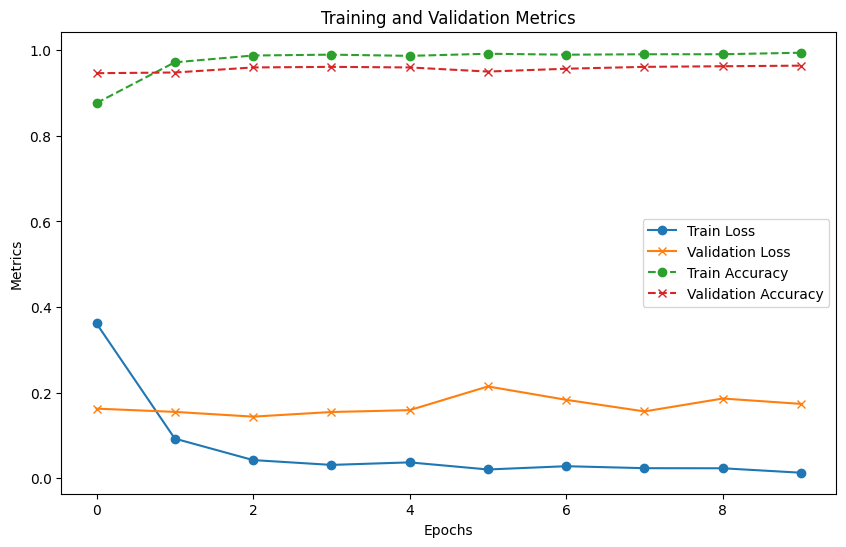

Training Time: 23826.44 seconds


<ipython-input-17-2651732b2fc1>:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


Confusion Matrix:
[[967  24   3   5   1]
 [ 20 943  11  20   6]
 [  6   7 986   1   0]
 [ 38  33   7 908  13]
 [  2   1   0   3 994]]
Classification Report:
              precision    recall  f1-score   support

        ACNE       0.94      0.97      0.95      1000
      CHCPOX       0.94      0.94      0.94      1000
       NEVUS       0.98      0.99      0.98      1000
 PSORİASİS       0.97      0.91      0.94       999
 VİTİLİGO       0.98      0.99      0.99      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999



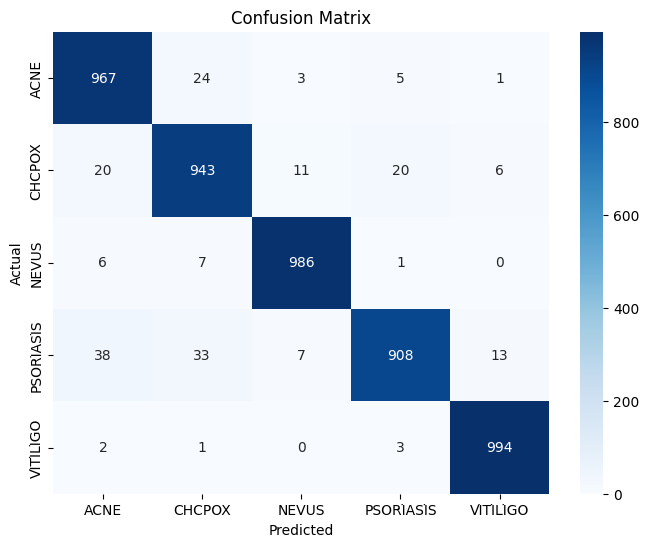

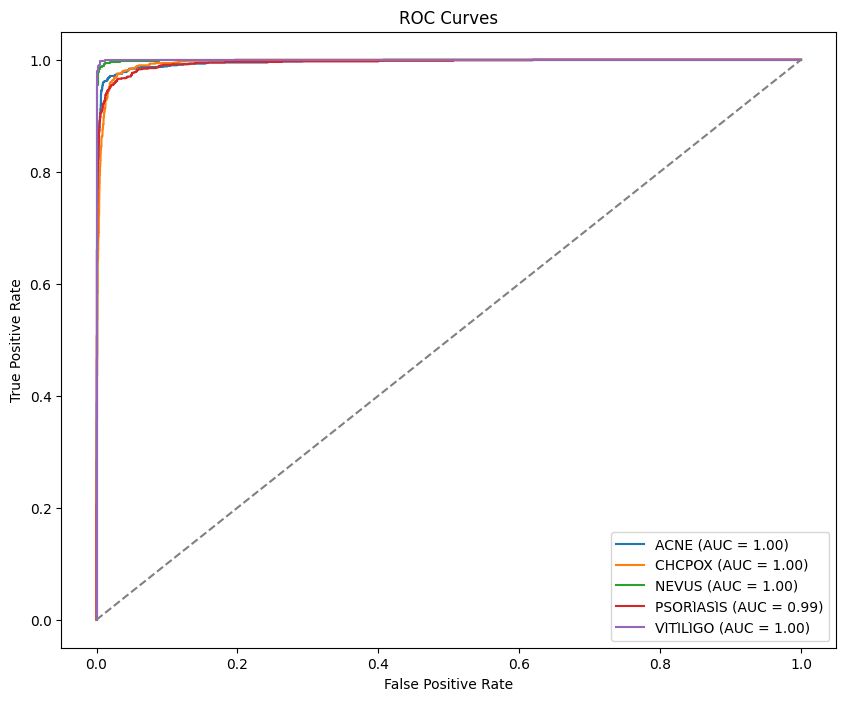

Training Time: 23826.44 seconds
Inference Time: 125.31 seconds
Training and Evaluation Completed.


In [ ]:
# @title Cait Transformer
import os
import time
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from timm import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

def prepare_dataset(directory, transform):
    file_paths = []
    labels = []
    class_to_idx = {}

    for idx, category in enumerate(sorted(os.listdir(directory))):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            class_to_idx[category] = idx
            for file_name in os.listdir(category_path):
                file_paths.append(os.path.join(category_path, file_name))
                labels.append(idx)

    dataset = CustomDataset(file_paths, labels, transform)
    return dataset, class_to_idx

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Paths to training and testing directories
train_dir = '/content/drive/MyDrive/Grup_36/ModelResimleri/train'
test_dir = '/content/drive/MyDrive/Grup_36/ModelResimleri/val'

# Check if the directories exist
if not os.path.exists(train_dir) or not os.listdir(train_dir):
    raise FileNotFoundError(f"Training directory not found or empty: {train_dir}")
if not os.path.exists(test_dir) or not os.listdir(test_dir):
    raise FileNotFoundError(f"Testing directory not found or empty: {test_dir}")

train_dataset, class_to_idx = prepare_dataset(train_dir, transform)
test_dataset, _ = prepare_dataset(test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load Cait model
model = create_model('cait_s24_224', pretrained=True)

# Reinitialize classifier to match the number of classes
model.head = torch.nn.Linear(model.num_features, len(class_to_idx))
torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

BEST_MODEL_PATH = "/content/drive/MyDrive/cait_best_model.pth"

def train_model_with_early_stopping(model, train_loader, test_loader, optimizer, epochs=10, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    start_time = time.time()

    try:
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            print(f"Epoch {epoch+1}/{epochs}")
            for images, labels in tqdm(train_loader, desc="Training", leave=False):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_accuracy = float(correct) / total if total > 0 else 0.0
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            val_loss, val_metrics = evaluate_model(model, test_loader, use_tqdm=True)
            val_accuracy = val_metrics['accuracy']
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                print(f"Validation loss improved to {val_loss:.4f}. Resetting patience counter.")
                torch.save(model.state_dict(), BEST_MODEL_PATH)
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    except Exception as e:
        print(f"Error during training: {e}")

    end_time = time.time()
    training_time = end_time - start_time

    # Plot Training and Validation Loss and Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='x')
    plt.plot(train_accuracies, label="Train Accuracy", linestyle='--', marker='o')
    plt.plot(val_accuracies, label="Validation Accuracy", linestyle='--', marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training and Validation Metrics")
    plt.show()

    print(f"Training Time: {training_time:.2f} seconds")
    return training_time

def evaluate_model(model, data_loader, use_tqdm=False):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating", leave=False) if use_tqdm else data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision, recall, fscore, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    fpr = {}
    tpr = {}
    roc_auc = {}
    sensitivity = {}
    specificity = {}
    for i, class_name in enumerate(class_to_idx):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    for i, class_name in enumerate(class_to_idx):
        fpr[class_name], tpr[class_name], _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys())))

    return total_loss / len(data_loader), {"accuracy": accuracy, "precision": precision, "recall": recall, "fscore": fscore, "confusion_matrix": cm, "roc_auc": roc_auc, "fpr": fpr, "tpr": tpr}

def plot_final_results(metrics):
    # Plot Confusion Matrix
    cm = metrics['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_to_idx.keys()), yticklabels=list(class_to_idx.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for class_name, roc_auc in metrics['roc_auc'].items():
        plt.plot(metrics['fpr'][class_name], metrics['tpr'][class_name], label=f"{class_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

def inference_time_with_error_handling(model, test_loader):
    try:
        start_time = time.time()
        model.eval()
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                _ = model(images)
        end_time = time.time()
        return end_time - start_time
    except Exception as e:
        print(f"Error during inference: {e}")
        return float('inf')

# Training
training_time = train_model_with_early_stopping(model, train_loader, test_loader, optimizer)

# Load the best model
try:
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
except Exception as e:
    print(f"Error loading the best model: {e}")

# Final Evaluation
val_loss, val_metrics = evaluate_model(model, test_loader, use_tqdm=True)

# Plot Results
plot_final_results(val_metrics)

# Inference time
inference_duration = inference_time_with_error_handling(model, test_loader)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_duration:.2f} seconds")
print("Training and Evaluation Completed.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
